# In group variablilty of WRs:
- Use ERA5 EDA control member
- Calculate composite z map
- Calculate variance at each grid point across all WR occurrences
- Compare to composites of uncertainty

In [1]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")


options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


Linking to GEOS 3.11.1, GDAL 3.6.2, PROJ 9.1.1; sf_use_s2() is TRUE

Lade nötiges Paket: maps


Attache Paket: ‘rnaturalearthdata’


Das folgende Objekt ist maskiert ‘package:rnaturalearth’:

    countries110


Lade nötiges Paket: abind


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Attache Paket: ‘purrr’


Das folgende Objekt ist maskiert ‘package:maps’:

    map



Attache Paket: ‘lubridate’


Das folgende Objekt ist maskiert ‘package:cowplot’:

    stamp


Die folgenden Objekte sind maskiert von ‘package:base’:

    date, intersect, setdiff, union



Attache Paket: ‘data.table’


Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


Das folgende Objekt ist maskiert ‘package:purrr’:

    transpose


Die folgenden Objekte sind maskiert von

In [2]:
result <- wrera(
    start = "19500111_00",
    end = "20250113_21",
    hours = c("00", "06", "12", "18"),
    tformat = "string",
    setup = "z500anom_1979_2019_on_wrdef_10d_1.0_1979_2019",
    dataset = "era5",
    basepath = "../WR_read_example_package/wr_era5_update_1950_latwgt/"
)

wr_df <- result$data$LC %>%
    filter(grepl("12$", time))
wr_df$date <- as.Date(wr_df$time, format = "%Y%m%d_%H")
tail(wr_df)


tsince,time,wrindex,wrname,date
<int>,<dttm>,<fct>,<fct>,<date>


In [3]:
# Get the z_control data
nc <- nc_open("../ens_data/data.nc")

num <- ncvar_get(nc, "number")
number_idx <- which(num == 0)
number_idx <- number_idx[1]
lon <- ncvar_get(nc, "longitude")
lat <- ncvar_get(nc, "latitude")
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))

start_vec <- c(1, 1, 1, number_idx)
count_vec <- c(-1, -1, -1, 1)
z_control <- ncvar_get(nc, "z", start = start_vec, count = count_vec)

nc_close(nc)


In [ ]:
z_comp <- calculate_wr_composites(z_control, time_whole, lon, lat, wr_df,
    calculate_variance = TRUE, n_perm = 100, n_cores = 10
)
z_comp$wr <- z_comp$wrindex
z_comp$p_value_adj <- p.adjust(z_comp$pval, method = "fdr")


In [5]:
z_comp <- readRDS("../ens_data/VarianceComposite.RDS")

str(z_comp)


Classes ‘data.table’ and 'data.frame':	271848 obs. of  9 variables:
 $ z          : num  51293 51288 51285 51280 51276 ...
 $ lon        : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...
 $ lat        : num  90 89.5 89 88.5 88 87.5 87 86.5 86 85.5 ...
 $ wrindex    : Factor w/ 8 levels "1","6","7","2",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ wrname     : Factor w/ 8 levels "AT","ZO","ScTr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ z_var      : num  -105635 -109989 -115818 -121659 -127653 ...
 $ pval       : num  0.774 0.793 0.82 0.846 0.865 ...
 $ wr         : Factor w/ 8 levels "1","6","7","2",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ p_value_adj: num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [7]:
pps <- grid_and_legend(z_comp,
    var = "z_var", sig_name = "pval", alpha = .05,
    clims = c(min(z_comp$z_var, na.rm = TRUE), max(z_comp$z_var, na.rm = TRUE))
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesVarianceLargeH.pdf", width = 11.5, height = 5.5)


Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven horizontal intervals and will be shifted
ℹ Consider using `geom_tile()` instead.”
Warning message:
“Raster pixels are placed at uneven ho

pdf 
  2

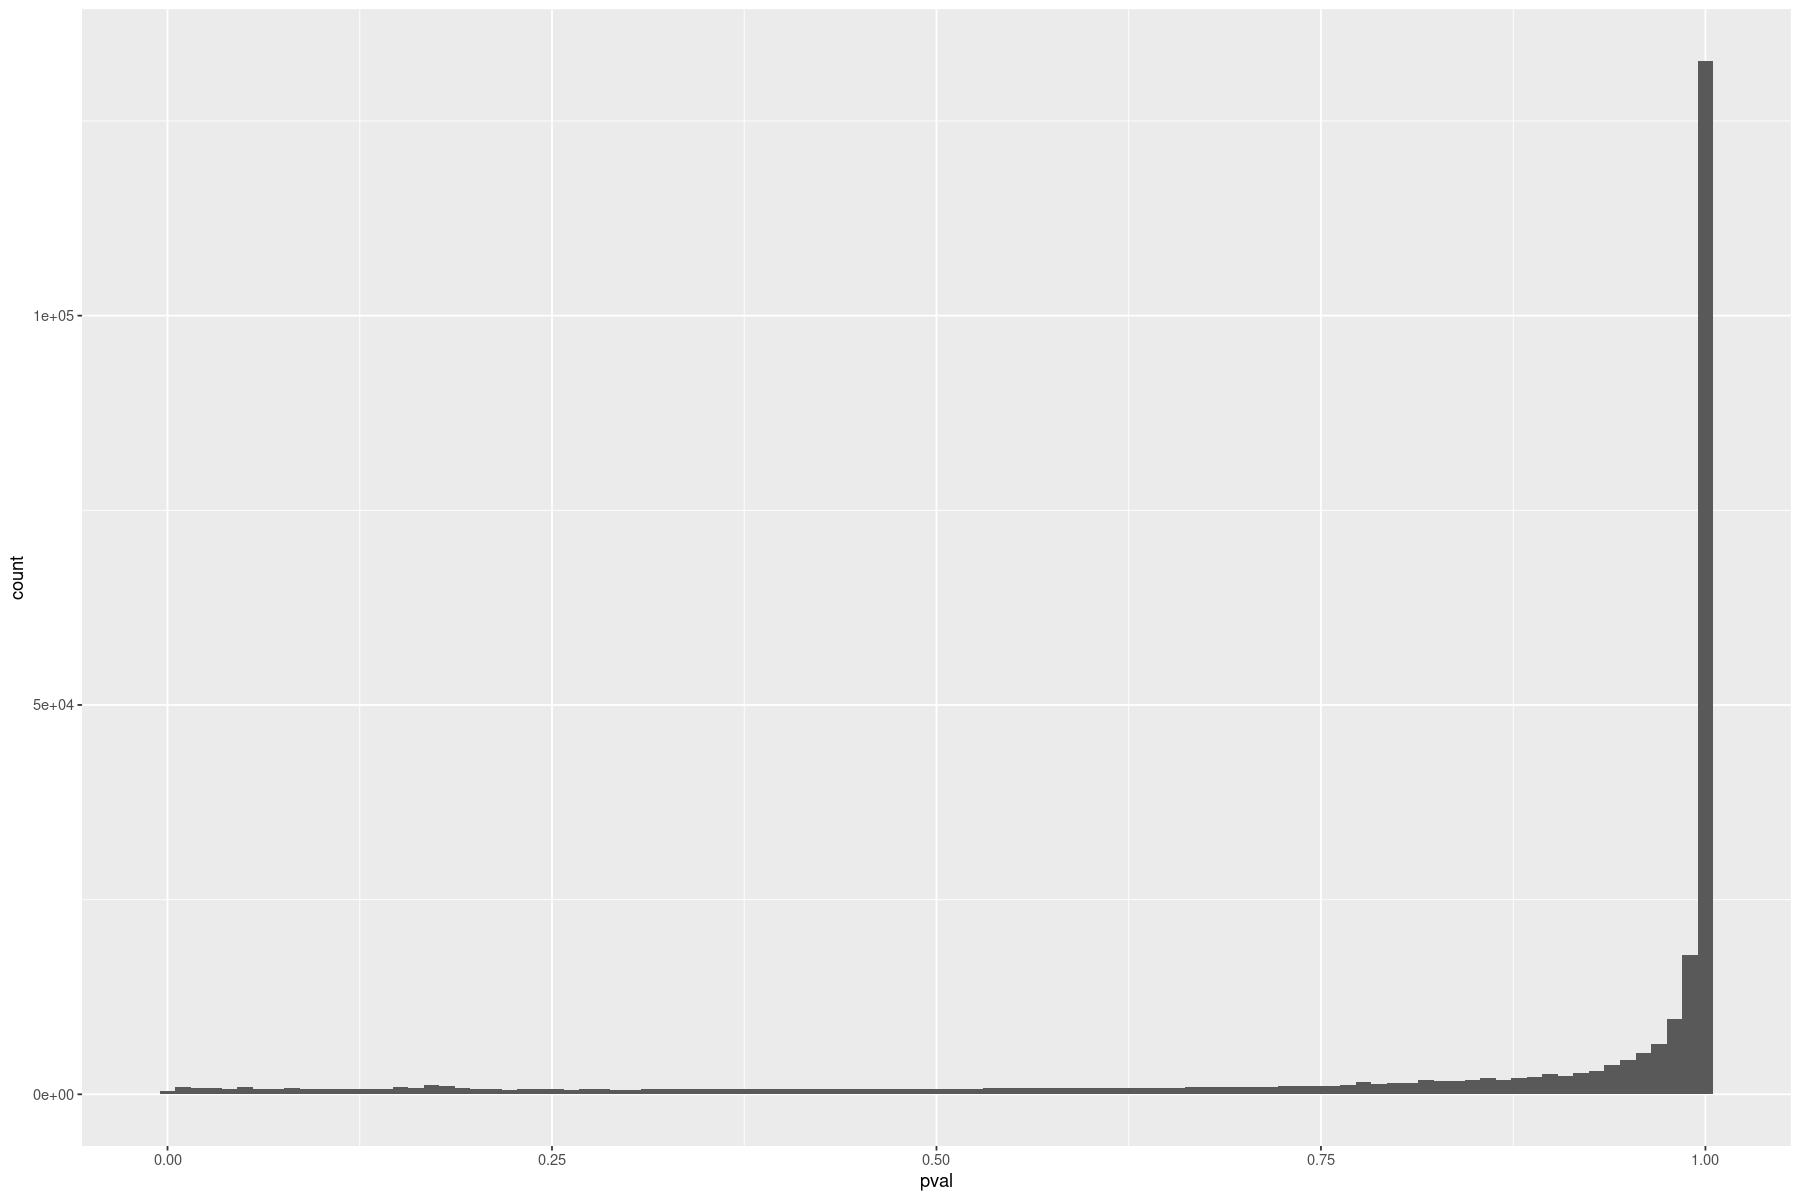

In [ ]:
# p-values make no sense as I calculated them
# They are the probability that the in-group variance is larger than the
# total dataset variance, which usually should be large
# 1-pval is more reasonable, but must be fdr adjusted. It is the probability
# that in-group variability is significantly smaller than total group
# variability
ggplot(z_comp, aes(x = pval)) +
    geom_histogram(bins = 100)


In [14]:
pps <- grid_and_legend(z_comp,
    var = "z_var", sig_name = "pval", alpha = 2,
    clims = c(min(z_comp$z_var, na.rm = TRUE), max(z_comp$z_var, na.rm = TRUE)),
    legend_name = "$(m^{2}s^{-2})^{2}$"
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesVarianceLargeH.pdf", width = 11.5, height = 5.5)


pdf 
  2

# What do Composites look like without the LMs?

In [36]:
raw_comp <- readRDS("../ens_data/Raw_WR_Comp.RDS")
str(raw_comp)


'data.frame':	463914 obs. of  6 variables:
 $ segment: Factor w/ 6 levels "-999","2","3",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ wrindex: Factor w/ 9 levels "-999","0","1",..: 1 2 6 7 3 4 5 9 8 1 ...
 $ mean   : num  4.4 4.45 4.37 4.25 4.37 ...
 $ p_val  : num  NA 0.0519 0.483 0.0002 0.5204 ...
 $ lat    : num  20 20 20 20 20 20 20 20 20 20 ...
 $ lon    : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...


In [37]:
all_levels <- union(levels(raw_comp$wrindex), levels(z_comp$wrindex))
z_comp$wrindex <- factor(z_comp$wrindex, levels = all_levels)
str(z_comp)


Classes ‘data.table’ and 'data.frame':	271848 obs. of  9 variables:
 $ z          : num  51293 51288 51285 51280 51276 ...
 $ lon        : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...
 $ lat        : num  90 89.5 89 88.5 88 87.5 87 86.5 86 85.5 ...
 $ wrindex    : Factor w/ 9 levels "-999","0","1",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ wrname     : Factor w/ 8 levels "AT","ZO","ScTr",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ z_var      : num  -105635 -109989 -115818 -121659 -127653 ...
 $ pval       : num  0.774 0.793 0.82 0.846 0.865 ...
 $ wr         : Factor w/ 8 levels "1","6","7","2",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ p_value_adj: num  1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [38]:
raw_comp <- full_join(raw_comp, z_comp %>% select(lon, lat, wrindex, wrname, z),
    by = c("lon" = "lon", "lat" = "lat", "wrindex" = "wrindex")
)
str(raw_comp)


'data.frame':	667034 obs. of  8 variables:
 $ segment: Factor w/ 6 levels "-999","2","3",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ wrindex: Factor w/ 9 levels "-999","0","1",..: 1 2 6 7 3 4 5 9 8 1 ...
 $ mean   : num  4.4 4.45 4.37 4.25 4.37 ...
 $ p_val  : num  NA 0.0519 0.483 0.0002 0.5204 ...
 $ lat    : num  20 20 20 20 20 20 20 20 20 20 ...
 $ lon    : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...
 $ wrname : Factor w/ 8 levels "AT","ZO","ScTr",..: NA 8 5 6 1 4 7 3 2 NA ...
 $ z      : num  NA 57420 57421 57467 57392 ...


In [39]:
total_means <- raw_comp %>%
    filter(wrindex == -999) %>%
    select(segment, mean, lat, lon) %>%
    rename(total_mean = mean)

str(total_means)


'data.frame':	51546 obs. of  4 variables:
 $ segment   : Factor w/ 6 levels "-999","2","3",..: 1 2 3 4 5 6 1 2 3 4 ...
 $ total_mean: num  4.4 5.62 5.07 4.32 3.72 ...
 $ lat       : num  20 20 20 20 20 20 20 20 20 20 ...
 $ lon       : num  -100 -100 -100 -100 -100 -100 -99 -99 -99 -99 ...


In [40]:
raw_comp <- raw_comp %>%
    full_join(total_means, by = c("segment", "lon", "lat"))


In [41]:
raw_comp <- raw_comp %>%
    mutate(anomaly = mean - total_mean, wr = wrindex)
str(raw_comp)


'data.frame':	667034 obs. of  11 variables:
 $ segment   : Factor w/ 6 levels "-999","2","3",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ wrindex   : Factor w/ 9 levels "-999","0","1",..: 1 2 6 7 3 4 5 9 8 1 ...
 $ mean      : num  4.4 4.45 4.37 4.25 4.37 ...
 $ p_val     : num  NA 0.0519 0.483 0.0002 0.5204 ...
 $ lat       : num  20 20 20 20 20 20 20 20 20 20 ...
 $ lon       : num  -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 ...
 $ wrname    : Factor w/ 8 levels "AT","ZO","ScTr",..: NA 8 5 6 1 4 7 3 2 NA ...
 $ z         : num  NA 57420 57421 57467 57392 ...
 $ total_mean: num  4.4 4.4 4.4 4.4 4.4 ...
 $ anomaly   : num  0 0.0416 -0.0317 -0.1516 -0.0306 ...
 $ wr        : Factor w/ 9 levels "-999","0","1",..: 1 2 6 7 3 4 5 9 8 1 ...


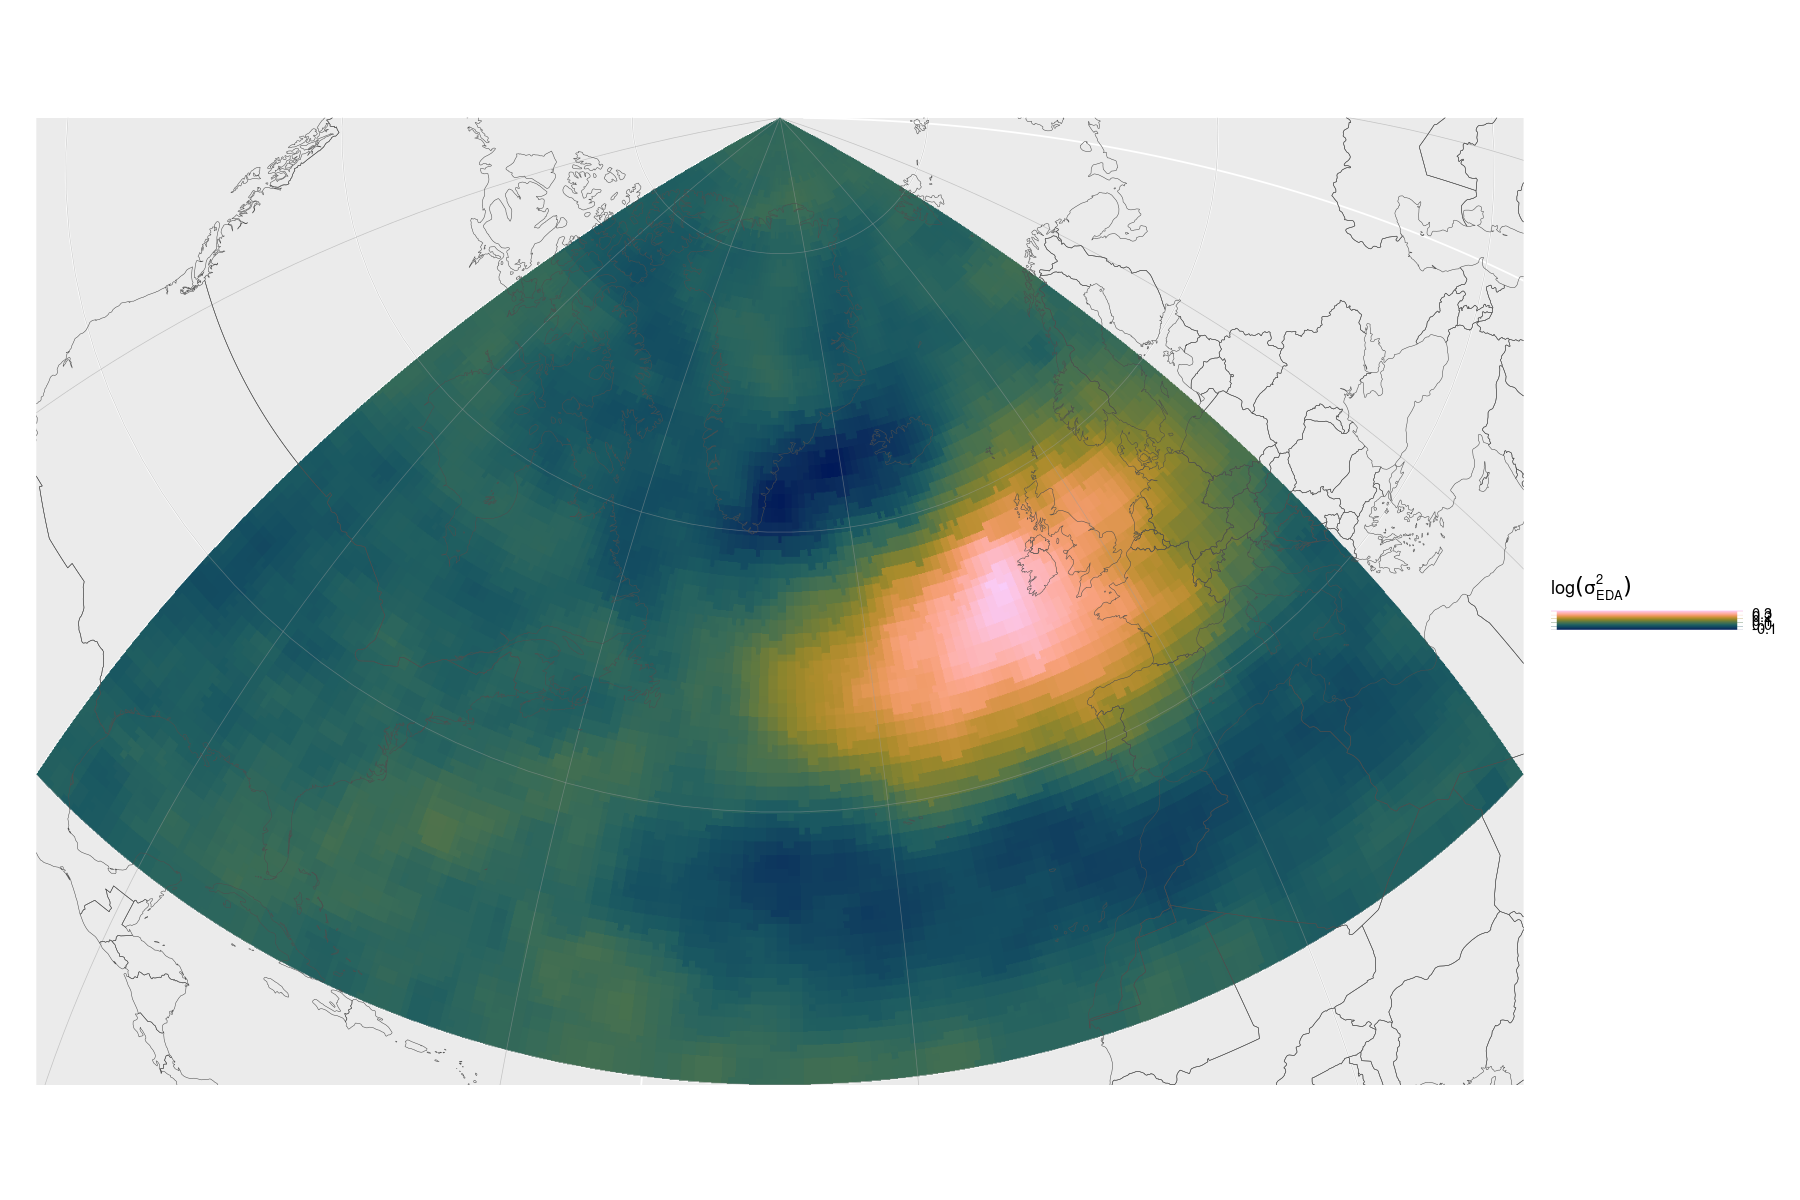

In [33]:
plot_spatial(raw_comp %>% filter(wr == 1), "anomaly",
    legend_name = "$\\log(\\sigma^{2}_{EDA})$",
    show_graticule_labels = FALSE,
    use_diverging = FALSE
)


In [42]:
pps <- grid_and_legend(raw_comp %>% filter(segment == -999, wrindex != -999),
    var = "anomaly", sig_name = "p_val", alpha = 2,
    clims = c(
        min(raw_comp$anomaly, na.rm = TRUE),
        max(raw_comp$anomaly, na.rm = TRUE)
    )
)
p <- combine_plots(pps[[1]], pps[[2]], "horizontal")
save_plot(p, "RegimesRawVarianceLargeH.pdf", width = 11.5, height = 5.5)


pdf 
  2